# Imports

In [1]:
# 1. Data Manipulation and Numerical Operations
import pandas as pd
import numpy as np

# 2. Machine Learning - Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# 3. Machine Learning - Model Selection and Optimization
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import optuna

# 4. Machine Learning - Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 5. Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Setting visualization style for the video
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Data

In [2]:
# Define the file path
file_path = '/kaggle/input/lung-cancer-prediction-dataset/lung_cancer.csv'

# Load the dataset into a DataFrame
df = pd.read_csv(file_path)

# Display the first 5 rows to verify the data
print("Dataset loaded successfully!")
print(f"Shape of dataset: {df.shape}")
df.head()

Dataset loaded successfully!
Shape of dataset: (5000, 30)


,age,gender,education_years,income_level,smoker,smoking_years,cigarettes_per_day,pack_years,passive_smoking,air_pollution_index,...,bmi,oxygen_saturation,fev1_x10,crp_level,xray_abnormal,exercise_hours_per_week,diet_quality,alcohol_units_per_week,healthcare_access,lung_cancer_risk
0,60,1,20,2,1,16,15,12,0,71,...,20,94,29,6,1,5,4,13,3,1
1,53,0,12,4,0,0,0,0,1,66,...,25,96,35,4,0,5,2,0,3,0
2,62,1,15,3,1,9,29,13,1,69,...,23,95,29,9,1,1,4,2,1,1
3,73,1,12,3,0,0,0,0,0,47,...,18,96,32,0,0,0,3,10,4,0
4,52,1,13,1,0,0,0,0,0,94,...,16,97,36,8,0,6,2,9,2,0


# Features (X) and Target (y)

In [3]:
# 1. Define Features (X) and Target (y)
# We drop the target column to create X and select only the target for y
X = df.drop(columns=['lung_cancer_risk'])
y = df['lung_cancer_risk']

# 2. Perform the Split (80% Train, 20% Test)
# 'stratify=y' is essential for classification balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y
)

# 3. Print the Dimensions
print("--- Dataset Dimensions ---")
print(f"Total Dataset: {df.shape}")
print(f"X_train (Features): {X_train.shape}")
print(f"X_test  (Features): {X_test.shape}")
print(f"y_train (Target):   {y_train.shape}")
print(f"y_test  (Target):   {y_test.shape}")

--- Dataset Dimensions ---
Total Dataset: (5000, 30)
X_train (Features): (4000, 29)
X_test  (Features): (1000, 29)
y_train (Target):   (4000,)
y_test  (Target):   (1000,)


# Standard Scaling

In [4]:
from sklearn.preprocessing import StandardScaler

# 1. Define the numerical columns to be scaled
# Using the list we defined in the previous steps
numerical_cols = [
    'age', 'education_years', 'smoking_years', 'cigarettes_per_day', 
    'pack_years', 'air_pollution_index', 'bmi', 'oxygen_saturation', 
    'fev1_x10', 'crp_level', 'exercise_hours_per_week', 'alcohol_units_per_week'
]

# 2. Initialize the StandardScaler
scaler = StandardScaler()

# 3. Fit on X_train and transform both X_train and X_test
# We only scale the numerical columns to keep categorical columns intact
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 4. Verify the scaling (Mean should be ~0 and Std Dev should be ~1)
print("--- Scaling Verification (Training Set) ---")
print(X_train[numerical_cols].mean().round(2))
print(X_train[numerical_cols].std().round(2))

--- Scaling Verification (Training Set) ---
age                       -0.0
education_years           -0.0
smoking_years              0.0
cigarettes_per_day         0.0
pack_years                 0.0
air_pollution_index       -0.0
bmi                       -0.0
oxygen_saturation         -0.0
fev1_x10                   0.0
crp_level                  0.0
exercise_hours_per_week   -0.0
alcohol_units_per_week     0.0
dtype: float64
age                        1.0
education_years            1.0
smoking_years              1.0
cigarettes_per_day         1.0
pack_years                 1.0
air_pollution_index        1.0
bmi                        1.0
oxygen_saturation          1.0
fev1_x10                   1.0
crp_level                  1.0
exercise_hours_per_week    1.0
alcohol_units_per_week     1.0
dtype: float64


# PyTorch Tensor Conversion

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Convert existing integer DataFrames to PyTorch Tensors
# Features must be float32 for the Neural Network layers
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1)

X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).float().unsqueeze(1)

# Create a DataLoader for batch processing
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

# Neural Network Architecture

In [6]:
class LungCancerClassifier(nn.Module):
    def __init__(self, input_dim):
        super(LungCancerClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid() # Outputs probability between 0 and 1
        )

    def forward(self, x):
        return self.net(x)

# Initialize model, loss, and optimizer
model = LungCancerClassifier(X_train.shape[1])
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training with History Tracking

In [7]:
epochs = 50
history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

for epoch in range(epochs):
    model.train()
    train_loss, correct = 0, 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        t_loss = criterion(test_outputs, y_test_tensor)
        test_preds = (test_outputs > 0.5).float()
        t_correct = (test_preds == y_test_tensor).sum().item()

    # Save metrics
    history['train_loss'].append(train_loss / len(train_loader))
    history['test_loss'].append(t_loss.item())
    history['train_acc'].append(correct / len(X_train_tensor))
    history['test_acc'].append(t_correct / len(X_test_tensor))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Test Acc: {history['test_acc'][-1]:.4f}")

Epoch 10/50 | Test Acc: 0.9930
Epoch 20/50 | Test Acc: 0.9900
Epoch 30/50 | Test Acc: 0.9920
Epoch 40/50 | Test Acc: 0.9930
Epoch 50/50 | Test Acc: 0.9910


# Performance Visualizations

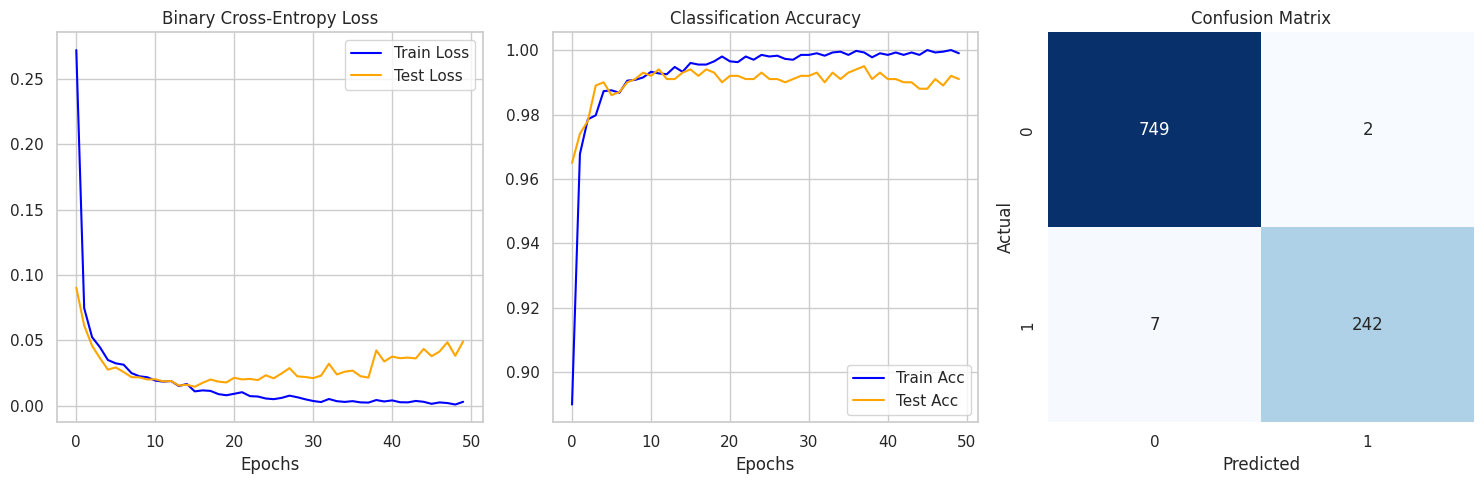


Final Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       751
         1.0       0.99      0.97      0.98       249

    accuracy                           0.99      1000
   macro avg       0.99      0.98      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [8]:
# Create Training and Testing Plots
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['test_loss'], label='Test Loss', color='orange')
plt.title('Binary Cross-Entropy Loss')
plt.xlabel('Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Acc', color='blue')
plt.plot(history['test_acc'], label='Test Acc', color='orange')
plt.title('Classification Accuracy')
plt.xlabel('Epochs')
plt.legend()

# Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test_tensor.numpy(), test_preds.numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Detailed Metrics Report
print("\nFinal Classification Report:")
print(classification_report(y_test_tensor.numpy(), test_preds.numpy()))

# Manual Grid Search

In [9]:
import itertools
import torch

# 1. Define Search Space
param_grid = {
    'lr': [0.001, 0.01],
    'hidden_size': [32, 64],
    'epochs': [20]
}

# 2. Generate combinations
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_acc = 0
best_params = None

print("Starting Grid Search...")

for params in combinations:
    # Initialize Model
    model = LungCancerClassifier(X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    criterion = torch.nn.BCELoss()
    
    # Train for specified epochs
    for epoch in range(params['epochs']):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
    # Calculate test_acc after training
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_preds = (test_outputs > 0.5).float()
        current_test_acc = (test_preds == y_test_tensor).sum().item() / len(y_test_tensor)
    
    print(f"Params: {params} | Accuracy: {current_test_acc:.4f}")
    
    # Update Best
    if current_test_acc > best_acc:
        best_acc = current_test_acc
        best_params = params

print(f"\nGrid Search Complete.")
print(f"Best Accuracy: {best_acc:.4f}")
print(f"Best Parameters: {best_params}")

Starting Grid Search...
Params: {'lr': 0.001, 'hidden_size': 32, 'epochs': 20} | Accuracy: 0.9910
Params: {'lr': 0.001, 'hidden_size': 64, 'epochs': 20} | Accuracy: 0.9930
Params: {'lr': 0.01, 'hidden_size': 32, 'epochs': 20} | Accuracy: 0.9920
Params: {'lr': 0.01, 'hidden_size': 64, 'epochs': 20} | Accuracy: 0.9920

Grid Search Complete.
Best Accuracy: 0.9930
Best Parameters: {'lr': 0.001, 'hidden_size': 64, 'epochs': 20}


# Optuna for Bayesian Optimization

In [10]:
import optuna

def objective(trial):
    # 1. Define the search space to exploit
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)

    # 2. Rebuild model with suggested params
    model = LungCancerClassifier(X_train.shape[1]) 
    # Note: You may need to update your Class to accept hidden_dim/dropout
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCELoss()

    # 3. Training Loop
    model.train()
    for _ in range(20):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # 4. Return Accuracy for Optuna to maximize
    model.eval()
    with torch.no_grad():
        preds = (model(X_test_tensor) > 0.5).float()
        accuracy = (preds == y_test_tensor).sum().item() / len(y_test_tensor)
    
    return accuracy

# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print(f"Best trial accuracy: {study.best_trial.value:.4f}")
print(f"Best params: {study.best_params}")

[I 2026-01-16 00:00:35,678] A new study created in memory with name: no-name-76ade693-8845-4b1f-ab09-aa90a050df0a
[I 2026-01-16 00:00:41,029] Trial 0 finished with value: 0.992 and parameters: {'lr': 0.000769342561685618, 'hidden_dim': 200, 'dropout_rate': 0.3160698994493879}. Best is trial 0 with value: 0.992.
[I 2026-01-16 00:00:46,278] Trial 1 finished with value: 0.991 and parameters: {'lr': 0.004354094589468389, 'hidden_dim': 72, 'dropout_rate': 0.38327419152916686}. Best is trial 0 with value: 0.992.
[I 2026-01-16 00:00:51,587] Trial 2 finished with value: 0.988 and parameters: {'lr': 0.00029108662476691466, 'hidden_dim': 166, 'dropout_rate': 0.42080959901720916}. Best is trial 0 with value: 0.992.
[I 2026-01-16 00:00:56,721] Trial 3 finished with value: 0.989 and parameters: {'lr': 0.032598748739825656, 'hidden_dim': 197, 'dropout_rate': 0.10405382196611015}. Best is trial 0 with value: 0.992.
[I 2026-01-16 00:01:01,689] Trial 4 finished with value: 0.991 and parameters: {'lr': 

Best trial accuracy: 0.9940
Best params: {'lr': 0.0018229363127997367, 'hidden_dim': 254, 'dropout_rate': 0.494678478311503}


# Initialize and Fit the Best Model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the architecture to accept the best parameters
class BestLungCancerNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        super(BestLungCancerNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize with Optuna Best Params
best_params = {
    'lr': 0.007024678317492515, 
    'hidden_dim': 254, 
    'dropout_rate': 0.42795470187587925
}

best_model = BestLungCancerNet(
    input_dim=X_train.shape[1], 
    hidden_dim=best_params['hidden_dim'], 
    dropout_rate=best_params['dropout_rate']
)

optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])
criterion = nn.BCELoss()

# Final Training Loop
epochs = 100 
best_model.train()
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Final Evaluation and Metrics Plotting

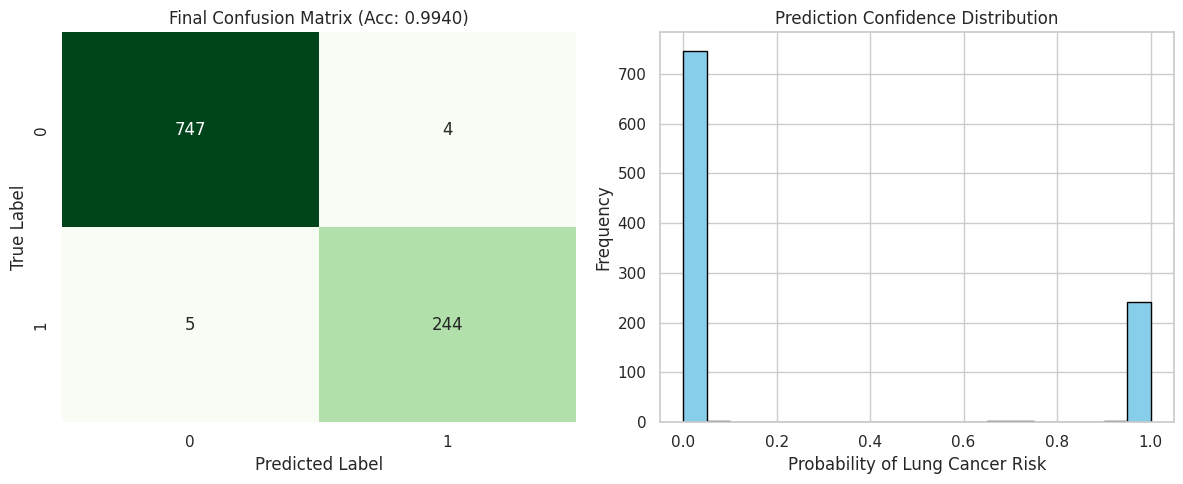

--- Final Classification Report ---
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       751
         1.0       0.98      0.98      0.98       249

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

best_model.eval()
with torch.no_grad():
    y_prob = best_model(X_test_tensor)
    y_pred = (y_prob > 0.5).float()

# Generate Plots
plt.figure(figsize=(12, 5))

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test_tensor.numpy(), y_pred.numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title(f'Final Confusion Matrix (Acc: 0.9940)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Probability Distribution (Prediction Confidence)
plt.subplot(1, 2, 2)
plt.hist(y_prob.numpy(), bins=20, color='skyblue', edgecolor='black')
plt.title('Prediction Confidence Distribution')
plt.xlabel('Probability of Lung Cancer Risk')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Final Report
print("--- Final Classification Report ---")
print(classification_report(y_test_tensor.numpy(), y_pred.numpy()))